In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import tol_colors as tc
from adjustText import adjust_text

textwidth_inches = 5.50107

In [2]:
model = 'Meta-Llama-3-8B-Instruct'
os.makedirs(f'../figures/{model}/', exist_ok=True)
rates_all_df = pd.read_csv(f'../results/steering_results_{model}.csv')

method_map = {'default': 'Default',
              'linear': 'Linear',
              'mean': 'DiffMean',
              'pca': 'PCAct',
              'repe': 'PCDiff',
              'random': 'Random',
              'refusal': 'Projection',
              'prompt': 'Prompt-only',
              'prompt-attention': 'InstABoost'
             }
data_map = {'JailbreakBench': 'Jailbreak',
            'AdvBench': 'Jailbreak',
            'TriviaQA': 'QA',
            'TruthfulQA': 'QA'
           }
rates_all_df['Data'] = rates_all_df['Data'].map(data_map).fillna(rates_all_df['Data'])

## Figure 1 - Prompt vs Latent Scatterplot

In [3]:
latent_steering = ['Linear', 'DiffMean', 'PCAct', 'PCDiff', 'Projection']
success_scatter = []
for sub, g in rates_all_df.groupby("Subcase"):
    id_prompt = g.loc[g["Method"] == 'Prompt-only', "Success rate"].idxmax()
    id_latent = g.loc[g["Method"].isin(latent_steering), "Success rate"].idxmax()
    id_instab = g.loc[g["Method"] == 'InstA-Boost', "Success rate"].idxmax()
    id_defaul = g.loc[g["Method"] == 'Default', "Success rate"].idxmax()

    success_scatter.append({'Name': sub, 
                            'Prompt': g.loc[id_prompt, "Success rate"], 
                            'Prompt - Lower': max(0, g.loc[id_prompt, "Score CI - Lower"]),
                            'Prompt - Upper': max(0, g.loc[id_prompt, "Score CI - Upper"]),
                            'Best latent': g.loc[id_latent, "Success rate"], 
                            'Best latent - Lower': max(0, g.loc[id_latent, "Score CI - Lower"]),
                            'Best latent - Upper': max(0, g.loc[id_latent, "Score CI - Upper"]),
                            'InstA-Boost': g.loc[id_instab, "Success rate"], 
                            'InstA-Boost - Lower': max(0, g.loc[id_instab, "Score CI - Lower"]),
                            'InstA-Boost - Upper': max(0, g.loc[id_instab, "Score CI - Upper"]),
                            'Default': g.loc[id_defaul, "Success rate"], 
                            'Default - Lower': max(0, g.loc[id_defaul, "Score CI - Lower"]),
                            'Default - Upper': max(0, g.loc[id_defaul, "Score CI - Upper"])
                           })

success_df = pd.DataFrame(success_scatter)
success_df['Diff'] = success_df['Best latent'] - success_df['Prompt']

In [5]:
tresh = 0.15
group1 = 'Latent-optimal'
group2 = 'Instruction-optimal'
group3 = 'Equivalent'

success_df['Group'] = ''
success_df.loc[success_df['Diff'] > tresh, 'Group'] = group1
success_df.loc[success_df['Diff'] < -tresh, 'Group'] = group2
success_df.loc[(success_df['Diff'] >= -tresh) & (success_df['Diff'] <= tresh), 'Group'] = group3
success_df['Name'] =  success_df['Name'].str[:1].str.upper() + success_df['Name'].str[1:]

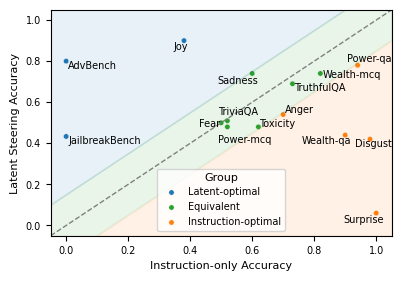

In [6]:
def plot_scatter_groups(success_df, tresh=tresh,
                        textwidth_inches = 5.50107,
                        label_fontsize: int = 8,
                        tick_fontsize: int = 7,
                        legend_fontsize: int = 7,
                        plot_regions = True):
    colors = sns.color_palette('tab10', n_colors=4)
    palette = {group1: colors[0],
               group2: colors[1],
               group3: colors[2]}
    
    fig, ax = plt.subplots(figsize=(textwidth_inches, textwidth_inches * (2/3)))
    
    scatter = sns.scatterplot(success_df, x='Prompt', y='Best latent', hue='Group',
                             palette=palette, s=15)
    
    ax.axline((0, 0), (1, 1), ls="--", c="gray", linewidth=1)
    ax.set_xlabel(f"Instruction-only Accuracy", fontsize=label_fontsize)
    ax.set_ylabel(f"Latent Steering Accuracy", fontsize=label_fontsize)
    
    if plot_regions:
        x = np.linspace(-0.05, 1.05, 20)
        y = np.linspace(-0.05, 1.05, 20)
        ax.fill_between(x, (y-tresh), (y+tresh), color=palette[group3], alpha=.1)
    
        ax.fill_between(x, y-tresh, -0.05, color=palette[group2], alpha=.1)
        ax.fill_between(x, y+tresh, 1.05, color=palette[group1], alpha=.1)

    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)
    
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    
    ax.legend(title='Group', fontsize=legend_fontsize, title_fontsize=label_fontsize,
             loc='lower center')
    
    texts = []
    points = []
    for _, r in success_df.iterrows():
        texts.append(ax.text(r.Prompt, r['Best latent'], r['Name'], ha="center", va="top", 
                             fontsize=tick_fontsize))
        points.append((r.Prompt, r['Best latent']))
    
    adjust_text(texts, points=points, ax=ax,
                only_move={'text':'xy'},
                expand_points=(1.5, 1.5),
                expand_text=(0.5, 0.5),
                force_points=(0.0, -0.5),
                force_text=(0.0, 0.2),
                lim=500)
    return fig

fig = plot_scatter_groups(success_df, textwidth_inches=0.8*textwidth_inches)
fig.savefig(f'../figures/{model}/scatter_groups.pdf', bbox_inches='tight')
plt.show()

## Figure 2 - Accuracy by Task Barplot

In [7]:
def plot_grouped_bars_subplot(ax, df, names_to_plot, method_order):
    """Helper function to generate a single grouped bar plot for a subplot."""
    df_filtered = df[df['Name'].isin(names_to_plot)].copy()
    unique_names = names_to_plot#sorted(df_filtered['Name'].unique())
    num_names = len(unique_names)
    num_methods = len(method_order)
    group_positions = np.arange(num_names)
    #palette = list(tc.tol_cset('bright'))[:num_methods]
    palette = sns.color_palette('tab10', n_colors=num_methods)
    palette.reverse()
    method_colors = {method: color for method, color in zip(method_order, palette)}
    bar_width = 0.8 / num_methods

    name_map = {
        "Power-mcq":   "Power\nMCQ",
        "Power-qa":    "Power\nQA",
        "Wealth-mcq":  "Wealth\nMCQ",
        "Wealth-qa":   "Wealth\nQA",
        "JailbreakBench": "Jailbreak\nBench"
    }
    wrapped_names = [name_map.get(n, n) for n in unique_names]
    method_map = {
        "Default": "None",
        "Best latent": "Best latent method",
        "Prompt": "Instruction-only",
        "InstA-Boost": "InstABoost"
    }
    
    for i, method in enumerate(method_order):
        if method in df_filtered.columns:
            y_values = df_filtered.groupby('Name')[method].mean().reindex(unique_names).values
            y_min = df_filtered.groupby('Name')[method+' - Lower'].mean().reindex(unique_names).values
            y_max = df_filtered.groupby('Name')[method+' - Upper'].mean().reindex(unique_names).values
            yerr_min = [y_values[i]-y_min[i] for i in range(len(y_values))]
            yerr_max = [y_max[i]-y_values[i] for i in range(len(y_values))]
            total_bar_width_group = num_methods * bar_width
            group_center = group_positions
            x_positions = group_center - (total_bar_width_group / 2) + i * bar_width
            ax.bar(x_positions, y_values, yerr=[yerr_min,yerr_max],
                   width=bar_width, label=method_map[method],
                   color=method_colors.get(method, 'gray'),
                   error_kw=dict(lw=0.5, capsize=2))

    ax.set_xticks(group_positions)
    ax.set_xticklabels(wrapped_names, fontsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1.05)
    for spine in ax.spines.values():
        spine.set_linewidth(0.7)
    ax.margins(x=0.02)

def plot_grouped_bars_three_subplots(df, names_row1, names_row2_left, names_row2_right,
                                    method_order=["Default", "Best latent", "Prompt", "InstA-Boost"],
                                    textwidth_inches=5.50107):
    """Generates a figure with three subplots with fixed bar width and adjusted layout."""
    fig = plt.figure(figsize=(textwidth_inches, textwidth_inches * 0.6))
    gs = fig.add_gridspec(2, 2, width_ratios=[len(names_row2_left), len(names_row2_right)],
                         wspace=0.04, hspace=0.45)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    plot_grouped_bars_subplot(ax1, df, names_row1, method_order)
    ax1.set_title('(a) Tasks where instruction and latent steering are equivalent', fontsize=8)
    ax1.set_ylabel('Accuracy', fontsize=7)

    plot_grouped_bars_subplot(ax2, df, names_row2_left, method_order)
    ax2.set_title('(b) '+group2+' tasks', fontsize=8)
    ax2.set_ylabel('Accuracy', fontsize=7)

    plot_grouped_bars_subplot(ax3, df, names_row2_right, method_order)
    ax3.set_title('(c) '+group1+' tasks', fontsize=8)
    #ax3.set_ylabel('Value', fontsize=7)
    ax3.tick_params(axis='y', which='both', left=False, labelleft=False)

    #scale = 0.75
    #for bar in ax3.patches:
    #    w  = bar.get_width()
    #    xc = bar.get_x() + w / 2
    #    new_w = w * scale
    #    bar.set_width(new_w)
    #    bar.set_x(xc - new_w / 2) 

    handles, labels = ax3.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.11),
               ncol=len(method_order), fontsize=7, title='Intervention', title_fontsize=8)

    return fig

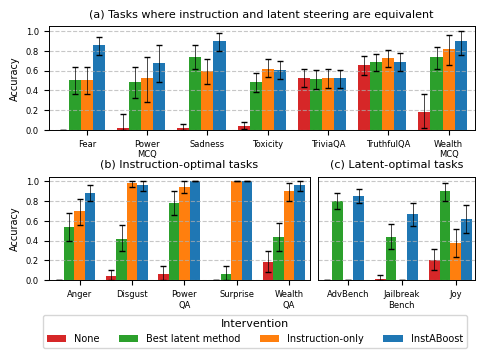

In [8]:
success_df = success_df.sort_values('Name')
names_row1 = success_df[success_df['Group'] == group3]['Name'].tolist()
names_row2_left = success_df[success_df['Group'] == group2]['Name'].tolist()
names_row2_right = success_df[success_df['Group'] == group1]['Name'].tolist()
fig_subplots = plot_grouped_bars_three_subplots(success_df, 
                                                names_row1, 
                                                names_row2_left,
                                                names_row2_right)
fig_subplots.savefig(f'../figures/{model}/bar_groups.pdf', bbox_inches='tight')

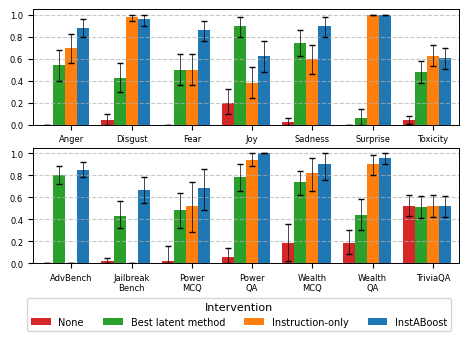

In [9]:
method_order=["Default", "Best latent", "Prompt", "InstA-Boost"]
fig, axs = plt.subplots(2,1,figsize=(textwidth_inches, textwidth_inches * 0.6))

plot_grouped_bars_subplot(axs[0], success_df, 
                          ['Anger', 'Disgust', 'Fear','Joy','Sadness', 'Surprise', 'Toxicity',],
                         method_order)
plot_grouped_bars_subplot(axs[1], success_df, 
                          ['AdvBench','JailbreakBench',
                           'Power-mcq', 'Power-qa','Wealth-mcq', 'Wealth-qa',
                          'TriviaQA'],
                         method_order)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.11),
           ncol=len(method_order), fontsize=7, title='Intervention', title_fontsize=8)
fig.savefig(f'../figures/{model}/bar_methods_qwen.pdf', bbox_inches='tight')

## Figure 3 - Accuracy vs Fluency Lineplot

In [10]:
base_path = f'../results/safety/{model}/'
methods = ['linear','mean','pca','repe','random']

latent_rates_list = []

for method in methods:
    param_path = os.path.join(base_path, 
                       f"{method}/best_params.json")
    with open(param_path, 'r') as file:
        param = json.load(file)

    val_path = os.path.join(base_path, f"{method}/validation_results.json")
    with open(val_path, 'r') as file:
        val_res = json.load(file)

    res = val_res[str(param['layer'])]
    res_pd = pd.DataFrame(res).T
    res_pd = res_pd.reset_index(names='Steering factor')
    res_pd['Method'] = method
    latent_rates_list.append(res_pd)    

latent_rates_df = pd.concat(latent_rates_list, ignore_index=True)
latent_rates_df['Method'] = latent_rates_df['Method'].map(method_map)

method = 'prompt-attention'
val_rates_path = os.path.join(base_path, 
                       f"{method}/acc_fluency.txt")
instab_rates_df = pd.read_csv(val_rates_path, names=['Steering factor','score','fluency'])
instab_rates_df['Method'] = 'InstABoost'

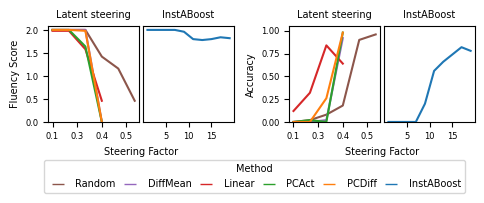

In [11]:
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.ticker as ticker

def plot_fluency_acc(rates_df, latent_rates_df,
                    smallfont = 6,
                    midfont = 7,
                    bigfont = 7):
    global textwidth_inches

    method_order = ['Random','DiffMean','Linear','PCAct','PCDiff','InstABoost']
    palette = sns.color_palette('tab10', n_colors=len(method_order))
    palette.reverse()
    method_colors = {method: color for method, color in zip(method_order, palette)}

    # Create the figure
    fig = plt.figure(figsize=(textwidth_inches, textwidth_inches * 0.3))

    # Define the GridSpec layout
    gs_outer = gridspec.GridSpec(1, 2, figure=fig, wspace=0.3, bottom=0.3, top=0.88)

    # Inner GridSpec for the left pair of plots (axs0, axs1)
    gs_left = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_outer[0], wspace=0.05)
    axs0 = fig.add_subplot(gs_left[0]) # Plots latent_rates_df
    axs1 = fig.add_subplot(gs_left[1]) # Plots rates_df (instab_rates_df)

    # Inner GridSpec for the right pair of plots (axs2, axs3)
    gs_right = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_outer[1], wspace=0.05)
    axs2 = fig.add_subplot(gs_right[0]) # Plots latent_rates_df
    axs3 = fig.add_subplot(gs_right[1]) # Plots rates_df (instab_rates_df)

    # Number of desired x-ticks
    num_x_ticks = 4

    # Plot 1: Fluency from latent_rates_df
    sns.lineplot(data=latent_rates_df, x='Steering factor', y='fluency', hue='Method',
                 ax=axs0, legend=False, palette=method_colors, hue_order=method_order)
    axs0.set_title('Latent steering', fontsize=bigfont)
    axs0.set_xlabel('')
    axs0.xaxis.label.set_visible(False)
    axs0.set_ylabel('Fluency Score', fontsize=midfont)
    axs0.tick_params(axis='x', labelsize=smallfont, bottom=True, labelbottom=True)
    axs0.tick_params(axis='y', labelsize=smallfont)
    #axs0.set_xlim(0, 0.6)
    axs0.xaxis.set_major_locator(ticker.MaxNLocator(num_x_ticks)) # Control number of x-ticks

    # Plot 2: Fluency from rates_df (e.g., instab_rates_df)
    sns.lineplot(data=rates_df, x='Steering factor', y='fluency', hue='Method',
                 ax=axs1, legend=False, palette=method_colors, hue_order=method_order)
    axs1.set_title('InstABoost', fontsize=bigfont)
    axs1.sharey(axs0)
    axs1.set_xlabel('')
    axs1.xaxis.label.set_visible(False)
    axs1.set_ylabel('')
    axs1.set_ylim(0.0, 2.08)
    axs1.tick_params(axis='y', left=False, labelleft=False)
    axs1.tick_params(axis='x', labelsize=smallfont, bottom=True, labelbottom=True)
    axs1.xaxis.set_major_locator(ticker.MaxNLocator(num_x_ticks)) # Control number of x-ticks

    # Plot 3: Success Rate from latent_rates_df
    sns.lineplot(data=latent_rates_df, x='Steering factor', y='score', hue='Method',
                 ax=axs2, legend=False, palette=method_colors, hue_order=method_order)
    axs2.set_title('Latent steering', fontsize=bigfont)
    axs2.set_xlabel('')
    axs2.xaxis.label.set_visible(False)
    axs2.set_ylabel('Accuracy', fontsize=midfont)
    axs2.tick_params(axis='x', labelsize=smallfont, bottom=True, labelbottom=True)
    axs2.tick_params(axis='y', labelsize=smallfont)
    #axs2.set_xlim(0, 0.6)
    axs2.set_ylim(0, 1.05)
    axs2.xaxis.set_major_locator(ticker.MaxNLocator(num_x_ticks)) # Control number of x-ticks

    # Plot 4: Success Rate from rates_df (e.g., instab_rates_df)
    sns.lineplot(data=rates_df, x='Steering factor', y='score', hue='Method',
                 ax=axs3, legend=False, palette=method_colors, hue_order=method_order)
    axs3.set_title('InstABoost', fontsize=bigfont)
    axs3.sharey(axs2)
    axs3.set_xlabel('')
    axs3.xaxis.label.set_visible(False)
    axs3.set_ylabel('')
    axs3.tick_params(axis='y', left=False, labelleft=False)
    axs3.tick_params(axis='x', labelsize=smallfont, bottom=True, labelbottom=True)
    axs3.xaxis.set_major_locator(ticker.MaxNLocator(num_x_ticks)) # Control number of x-ticks

    fig.canvas.draw() # Ensure the canvas is drawn so positions are finalized

    # Calculate positions for centered X-axis labels
    pos0 = axs0.get_position(fig)
    pos1 = axs1.get_position(fig)
    x_center_pair1 = (pos0.x0 + pos1.x1) / 2

    pos2 = axs2.get_position(fig)
    pos3 = axs3.get_position(fig)
    x_center_pair2 = (pos2.x0 + pos3.x1) / 2

    xlabel_y_position = fig.subplotpars.bottom - 0.15
    if xlabel_y_position < 0.1: # Ensure y_position is not too low
        xlabel_y_position = 0.15

    fig.text(x_center_pair1, xlabel_y_position, 'Steering Factor', 
             ha='center', va='top', fontsize=midfont)
    fig.text(x_center_pair2, xlabel_y_position, 'Steering Factor', 
             ha='center', va='top', fontsize=midfont)

    legend_handles = []
    for method_name in method_order:
        if method_name in method_colors: # Check if the method has a defined color
            # Create a line artist for the legend
            line = mlines.Line2D([], [], color=method_colors[method_name],
                                 marker='_', # Using a short line marker, common for line plots
                                 markersize=8, # Adjust marker size as needed
                                 linestyle='None', # No connecting line, just the marker
                                 label=method_name)
            legend_handles.append(line)
        else:
            print(f"Warning: Method '{method_name}' in method_order not found in method_colors. Skipping for legend.")

    if legend_handles:
        fig.legend(handles=legend_handles,
                   title='Method',
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.16),
                   ncol=max(1, len(legend_handles)),
                   fontsize=midfont,
                   title_fontsize=midfont,
                   columnspacing=0.5)
    else:
        print("Warning: No legend items could be created. Check 'method_order' and 'method_colors'.")
    
    return fig

fig = plot_fluency_acc(instab_rates_df, latent_rates_df)
fig.savefig(f'../figures/{model}/fluency_acc_advbench.pdf', bbox_inches='tight')
plt.show()